In [12]:
#Set Grid Size
gridsize=.002
#Set threshhold
thresholdPercentage=60

In [13]:
import geopandas as gpd
import queue as Q
import time
from statistics import median
from shapely.geometry import Polygon,Point,LineString
import shapefile
import math
import matplotlib.pyplot as plt
import numpy as np
from geopandas.tools import sjoin
#shapefile object
sf=shapefile.Reader('crime_dt.shp')
#geopandas object
pointsData = gpd.read_file('crime_dt.shp')

In [14]:
xmin,ymin,xmax,ymax =  pointsData.total_bounds
#xmin=-73.59
#ymin=45.49
#xmax=-73.55
#ymax=45.53
#Create Column and Rows of grid
cols=np.arange(xmin,xmax,gridsize)
rows=np.arange(ymin,ymax,gridsize)
#List for Polygons
createPolygons=[]
#List for Points
gridPoints=[]
xCordPoint=[]
yCordPoint=[]
#Loop for creating polygons
for i in rows:
    y1=i
    y2=y1+gridsize
    for j in cols:
        xCordPoint.append(i)
        yCordPoint.append(j)
        gridPoints.append(Point(i,j))
        x1=j
        x2=x1+gridsize
        createPolygons.append(Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)]))

In [15]:
#setting projections
crs = {'init' :'epsg:4326'}
#Putting in DataFrame
grid=gpd.GeoDataFrame({'geometry':createPolygons},crs=crs)
#Writing and Reading Shape File
grid.to_file("grid.shp")
polygonsData=gpd.read_file("grid.shp")
pointInPolys = sjoin(pointsData, polygonsData, how='left')

In [16]:
finalPrint=[]
#List for calculating median,mean and standard deviation
sortColor=[]
for index,row in grid.iterrows():
    attachPoints =  pointInPolys[pointInPolys.FID ==index ]
    finalPrint.append(len(attachPoints))
    sortColor.append(len(attachPoints))

sortColor.sort()
flag=False
#for calculating threshold on the basis of percentage
if thresholdPercentage==50:
    th=median(sortColor)
else:
    medianCalculation=math.floor((len(finalPrint)*thresholdPercentage)/100)
    th=sortColor[medianCalculation]

print("Median:",th)   
print("Mean:",np.mean(finalPrint))
print("Standard Deviation",np.std(finalPrint))

Median: 49
Mean: 47.525
Standard Deviation 47.7950245841552


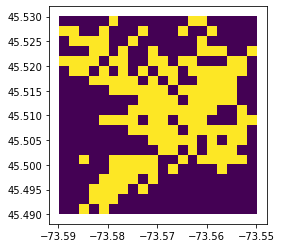

In [17]:
color=[]
FID=[]
countID=0
if th==0:
    th=1
for x in finalPrint:
    if x>=th:
        FID.append(countID)
        countID=countID+1
        color.append('yellow')
    else:
        FID.append(countID)
        countID=countID+1
        color.append('purple')
gridFinal=gpd.GeoDataFrame({'geometry':createPolygons,'NPoints':finalPrint,'colors':color,'FID':FID},crs=crs)
gridFinal.plot(cmap='viridis',column='colors')
Matrix = np.arange(len(finalPrint)).reshape((len(rows), len(cols)))
new=np.flip(Matrix,0)
newRow=len(rows)
newCol=len(cols)
length=newRow*newCol
colorGraph={}
for x in new:
    for y in x:
        res=gridFinal[gridFinal.FID==y]
        res=res['colors']
        colorGraph[y]=str(res.iloc[0])

In [18]:
def assignValue(first,second):
    if(first=='purple' and second=='purple'):
        return 1
    elif(first=='purple' and second =='yellow'):
        return 1.3
    elif(first=='yellow' and second =='purple'):
        return 1.3
newGraph={}
for x in new:
    for y in x:
        localList=[]
        #for first polygon we dont include in graph as edge case
        if y==0:
            pass
                  
        #not include as edge case top left polygon due to edge condition
        elif y==((newRow*newCol)-newCol):
            pass
        
        #for second node in top row
        elif y==((newRow*newCol)-newCol+1):
            #for stright right
            if(colorGraph[y]=='yellow' and colorGraph[y-newCol]=='yellow'):
                pass
            else:
                localList.append((y+1,assignValue(colorGraph[y],colorGraph[y-newCol])))
            #for straight down line
            if(colorGraph[y-len(cols)]=='yellow' and colorGraph[y-len(cols)-1]=='yellow'):
                pass
            else:
                localList.append((y-len(cols),assignValue(colorGraph[y-len(cols)],colorGraph[y-len(cols)-1])))
            #diagnal straight down right
            if(colorGraph[y-newCol]=='yellow'):
                pass
            else:
                localList.append((y-len(cols)+1,1.5))
            newGraph[y]=localList
                 
        #top right:polygons bottom left point 
        elif y==((newRow*newCol)-1):
            #for straight down line
            if(colorGraph[y-len(cols)]=='yellow' and colorGraph[y-len(cols)-1]=='yellow'):
                pass
            else:
                localList.append((y-len(cols),assignValue(colorGraph[y-len(cols)],colorGraph[y-len(cols)-1])))
            #for diagnal
            if(colorGraph[y-len(cols)-1]=='yellow'):
                pass
            else:
                localList.append((y-len(cols)-1,1.5))
            #for straight left
            if(colorGraph[y-1]=='yellow' and y-len(cols)-1=='yellow'):
                pass
            else:
                localList.append((y-1,assignValue(colorGraph[y-1],colorGraph[y-len(cols)-1])))
            newGraph[y]=localList
        
        #bottom right polygon point
        elif y==(newCol-1):
            pass
        
        #for uper Row 2 ..second last element
        elif(y==2*newCol-1):
             #for diagnal left
            if(colorGraph[y-1]=='yellow'):
                pass
            else:
                localList.append((y+len(cols)-1,1.5))
                
            #for straight left
            if(colorGraph[y-1]=='yellow' and colorGraph[y-len(cols)-1]=='yellow'):
                pass
            else:
                localList.append((y-1,assignValue(colorGraph[y-1],colorGraph[y-len(cols)-1])))
            #straight up
            if(colorGraph[y-1]=='yellow' and colorGraph[y]=='yellow'):
                pass
            else:
                localList.append((y+len(cols),assignValue(colorGraph[y-1],colorGraph[y])))
            newGraph[y]=localList
                
        #Bottom Row
        elif y<newCol:
            pass
            
        #Upper Polygons
        elif y<(newRow*newCol-1) and y>(newRow*newCol-newCol):
            #for straight down
            if(colorGraph[y-len(cols)]=='yellow' and colorGraph[y-len(cols)-1]=='yellow'):
                pass
            else:
                localList.append((y-len(cols),assignValue(colorGraph[y-len(cols)],colorGraph[y-len(cols)-1])))
            #for diagnal left
            if(colorGraph[y-len(cols)-1]=='yellow'):
                pass
            else:
                localList.append((y-len(cols)-1,1.5))
            #for right diagnal
            if(colorGraph[y-len(cols)]=='yellow'):
                pass
            else:
                localList.append((y-len(cols)+1,1.5))     
            #for straight left
            if(colorGraph[y-1]=='yellow' and colorGraph[y-len(cols)-1]=='yellow'):
                pass
            else:
                localList.append((y-1,assignValue(colorGraph[y-1],colorGraph[y-len(cols)-1])))
            #for straight right
            if(colorGraph[y]=='yellow' and colorGraph[y-len(cols)]=='yellow'):
                pass
            else:
                localList.append((y+1,assignValue(colorGraph[y],colorGraph[y-len(cols)])))             
            newGraph[y]=localList
            
        #for bottom polygon
        elif (y>0 and y<newCol-1):
            pass
            
        #for left column
        elif y%newCol==0:
            pass
            
        #for 2 node on 2 row from bottom
        elif ((y-1)%newCol==0 and y==newCol+1):
             #straight right
            if(colorGraph[y]=='yellow' and colorGraph[y-len(cols)]=='yellow'):
                pass
            else:
                localList.append((y+1,assignValue(colorGraph[y],colorGraph[y-len(cols)]))) 
            #straight up 
            if(colorGraph[y-1]=='yellow' and colorGraph[y]=='yellow'):
                pass
            else:
                localList.append((y+len(cols),assignValue(colorGraph[y-1],colorGraph[y])))
            #diagnal straight up
            if(colorGraph[y]=='yellow'):
                pass
            else:
                localList.append((y+len(cols)+1,1.5))
            newGraph[y]=localList
            
        #for 2 row from bottom
        elif(y>newCol+1 and y<(2*newCol-1)):
             #straight right
            if(colorGraph[y]=='yellow' and colorGraph[y-len(cols)]=='yellow'):
                pass
            else:
                localList.append((y+1,assignValue(colorGraph[y],colorGraph[y-len(cols)]))) 
            #for straight left
            if(colorGraph[y-1]=='yellow' and colorGraph[y-len(cols)-1]=='yellow'):
                pass
            else:
                localList.append((y-1,assignValue(colorGraph[y-1],colorGraph[y-len(cols)-1])))
            #straight up 
            if(colorGraph[y-1]=='yellow' and colorGraph[y]=='yellow'):
                pass
            else:
                localList.append((y+len(cols),assignValue(colorGraph[y-1],colorGraph[y])))
            #diagnal straight up left
            if(colorGraph[y-1]=='yellow'):
                pass
            else:
                localList.append((y+len(cols)-1,1.5))
             #diagnal straight up right
            if(colorGraph[y]=='yellow'):
                pass
            else:
                localList.append((y+len(cols)+1,1.5))
            newGraph[y]=localList
        
        #for 2 column from the left
        elif (y%newCol)-1==0:
            #straight down
            if(colorGraph[y-len(cols)]=='yellow' and colorGraph[y-len(cols)-1]=='yellow'):
                pass
            else:
                localList.append((y-len(cols),assignValue(colorGraph[y-len(cols)],colorGraph[y-len(cols)-1])))
            #straight right
            if(colorGraph[y]=='yellow' and colorGraph[y-len(cols)]=='yellow'):
                pass
            else:
                localList.append((y+1,assignValue(colorGraph[y],colorGraph[y-len(cols)]))) 
            #straight up 
            if(colorGraph[y-1]=='yellow' and colorGraph[y]=='yellow'):
                pass
            else:
                localList.append((y+len(cols),assignValue(colorGraph[y-1],colorGraph[y])))
            #diagnal straight up right
            if(colorGraph[y]=='yellow'):
                pass
            else:
                localList.append((y+len(cols)+1,1.5))
            #diagnal straight down
            if(colorGraph[y-len(cols)]=='yellow'):
                pass
            else:
                localList.append((y-len(cols)+1,1.5))
            newGraph[y]=localList
        
        #right most Column 
        elif (y+1)%newCol==0:
            #straight down
            if(colorGraph[y-len(cols)]=='yellow' and colorGraph[y-len(cols)-1]=='yellow'):
                pass
            else:
                localList.append((y-len(cols),assignValue(colorGraph[y-len(cols)],colorGraph[y-len(cols)-1])))
            #straight up
            if(colorGraph[y-1]=='yellow' and colorGraph[y]=='yellow'):
                pass
            else:
                localList.append((y+len(cols),assignValue(colorGraph[y-1],colorGraph[y])))
            #diagnal straight up left
            if(colorGraph[y-1]=='yellow'):
                pass
            else:
                localList.append((y+len(cols)-1,1.5))
            #diagnal straight down left
            if(colorGraph[y-newCol-1]=='yellow'):
                pass
            else:
                localList.append((y-len(cols)-1,1.5))
            #for straight left
            if(colorGraph[y-1]=='yellow' and colorGraph[y-len(cols)-1]=='yellow'):
                pass
            else:
                localList.append((y-1,assignValue(colorGraph[y-1],colorGraph[y-len(cols)-1])))
            newGraph[y]=localList
            
        else:
            #straight down
            if(colorGraph[y-len(cols)]=='yellow' and colorGraph[y-len(cols)-1]=='yellow'):
                pass
            else:
                localList.append((y-len(cols),assignValue(colorGraph[y-len(cols)],colorGraph[y-len(cols)-1])))
            #straight up
            if(colorGraph[y-1]=='yellow' and colorGraph[y]=='yellow'):
                pass
            else:
                localList.append((y+len(cols),assignValue(colorGraph[y-1],colorGraph[y])))
            #diagnal straight up left
            if(colorGraph[y-1]=='yellow'):
                pass
            else:
                localList.append((y+len(cols)-1,1.5))
            #diagnal straight down left
            if(colorGraph[y-newCol-1]=='yellow'):
                pass
            else:
                localList.append((y-len(cols)-1,1.5))
            #diagnal straight down right
            if(colorGraph[y-newCol]=='yellow'):
                pass
            else:
                localList.append((y-len(cols)+1,1.5))
            #diagnal straight up right
            if(colorGraph[y]=='yellow'):
                pass
            else:
                localList.append((y+len(cols)+1,1.5))
             #straight right
            if(colorGraph[y]=='yellow' and colorGraph[y-len(cols)]=='yellow'):
                pass
            else:
                localList.append((y+1,assignValue(colorGraph[y],colorGraph[y-len(cols)]))) 
            #for straight left
            if(colorGraph[y-1]=='yellow' and colorGraph[y-len(cols)-1]=='yellow'):
                pass
            else:
                localList.append((y-1,assignValue(colorGraph[y-1],colorGraph[y-len(cols)-1])))
            newGraph[y]=localList
            
            
t0=time.clock()
t0=time.time()
checkFirstPolygon=len(rows)-1
res=gridFinal[gridFinal.FID==checkFirstPolygon]
res=res['colors']
checkLastPolygon=len(finalPrint)-len(cols)
res1=gridFinal[gridFinal.FID==checkLastPolygon]
res1=res1['colors']
#if purple good to go
flag=False
if((str(res.iloc[0])=='purple') and (str(res1.iloc[0])=='purple') ):
    flag=True



/home/nishant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:273: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


/home/nishant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]


For Best First Search with 2nd heuristic
Node Processed: 682
Cost: 60.19999999999999
Running Time: 0.17431092262268066 Seconds


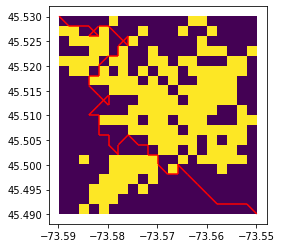

In [36]:
import random
def randomHeuristic(currentNode):
    xCurrentNode=xCordPoint[currentNode]
    yCurrentNode=yCordPoint[currentNode]
    xGoalNode=xCordPoint[2*newCol-1]
    yGoalNode=yCordPoint[2*newCol-1]
    differenceX=abs(xCurrentNode-xGoalNode)
    differenceY=abs(yCurrentNode-yGoalNode)
    r=random.randint(1,100)
    if(r%3==0):
        return (max(differenceX,differenceY))
    return differenceX+differenceY
t0=time.clock()
t0=time.time()
#For Best First Search
P2queue=Q.PriorityQueue()
P2queue.put((0,length-newCol+1))
B2closedNodeSet=set()
B2openNodeSet=set([length-newCol+1])
B2parent={}
B2path=[]
B2nodeProcessed=0
while not P2queue.empty() and flag==True:
    value,extractedNode=P2queue.get()
    B2closedNodeSet.add(extractedNode)
    if extractedNode==2*newCol-1:
        localVarPath=[extractedNode]
        while extractedNode in B2parent:
            extractedNode=B2parent[extractedNode]
            localVarPath.append(extractedNode)
        localVarPath.reverse()
        B2path=localVarPath
        break
    for x in newGraph[extractedNode]:
        node,value=x
        if(node not in B2closedNodeSet and node not in B2openNodeSet):
            P2queue.put((randomHeuristic(node),node))
            B2nodeProcessed=B2nodeProcessed+1
            B2openNodeSet=set([node])
            B2parent[node]=extractedNode

line=[]
if(flag==False or len(B2path)==1 or len(B2path)==0):
    print("No Path Found")
else:
    B2cost=0
    for x in range(0,len(B2path)-1):
        for y in newGraph[B2path[x]]:
            a,b=y
            if(a==B2path[x+1]):
                B2cost=B2cost+b
    print("For Best First Search with random heuristic")
    print("Node Processed:",B2nodeProcessed)       
    print("Cost:",B2cost+3)
    line.append(LineString([[yCordPoint[length-newCol],xCordPoint[length-newCol]+gridsize],[yCordPoint[length-newCol+1],xCordPoint[length-newCol+1]]]))
    for x in range(0,len(B2path)-1):
        line.append(LineString([[yCordPoint[B2path[x]],xCordPoint[B2path[x]]],[yCordPoint[B2path[x+1]],xCordPoint[B2path[x+1]]]]))
    line.append(LineString([[yCordPoint[2*newCol-1],xCordPoint[2*newCol-1]],[yCordPoint[newCol-1]+gridsize,xCordPoint[newCol-1]]]))
    LineS=gpd.GeoDataFrame({'geometry':line},crs=crs)
    fig,ax=plt.subplots()
    gridFinal.plot(column='colors',cmap='viridis',ax=ax)
    LineS.plot(ax=ax,color='red')
print("Running Time:",time.time()-t0,"Seconds")